Date: 9/6/2024



# Part 1: Generating Data

In [ ]:
# Imports & setting seed
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle

np.random.seed(42)

In [ ]:
# Generate 20 Centers, 1.1
csize = 10
p = 2
s = 1    # sd for generating the centers within each class
m1 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[1, 0]] * csize)])
m0 = np.random.normal(size = (csize, p)) * s \
     + np.concatenate([np.array([[0, 1]] * csize)])


[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


In [ ]:
# n size of 100 for each of 2 groups
n = 100
# Randomly allocate the n samples for class 1  to the 10 clusters
id1 = np.random.randint(csize, size = n)
id0 = np.random.randint(csize, size = n)

# sd for generating data
s = np.sqrt(float(1)/5)
# Generate training data, 1.2
X_train = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])
y_train = np.concatenate(([1]*n, [0]*n))
X_train.shape

(200, 2)

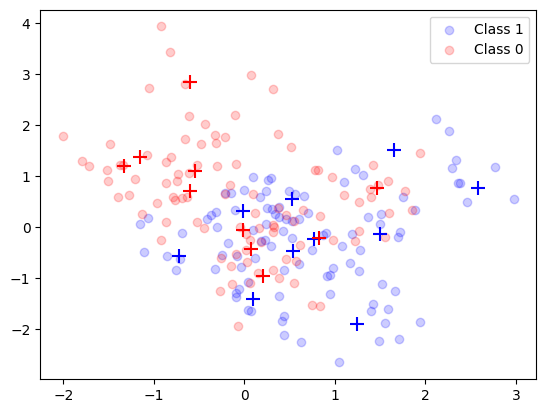

In [ ]:
# Plot Training data, 1.3
plt.scatter(X_train[:n, 0], X_train[:n, 1], c = "blue", alpha=0.2, label='Class 1')
plt.scatter(X_train[n:, 0], X_train[n:, 1], c = "red", alpha=0.2, label='Class 0')

plt.scatter(m1[:,0], m1[:,1], marker = '+', s = 100, c = "blue")
plt.scatter(m0[:,0], m0[:,1], marker = '+', s = 100, c = "red")

plt.legend()
plt.show()

In [ ]:
# Generate Test data using same centers, 1.2
n = 5000
id1 = np.random.randint(csize, size = n)
id0 = np.random.randint(csize, size = n)

# sd for generating data
s = np.sqrt(float(1)/5)

X_test = np.random.normal(size = (2 * n, p)) * s \
            + np.concatenate([m1[id1,:], m0[id0,:]])
y_test = np.concatenate(([1]*n, [0]*n))
X_test.shape

(10000, 2)

# Part 2: kNN

### Question 2.1:

In [ ]:
# Citation: https://jaykmody.com/blog/distance-matrices-with-numpy/

def euclidean_dist(m1, m2):

  x2 = np.sum(m1**2, axis=1)
  y2 = np.sum(m2**2, axis=1)

  xy = np.matmul(m1, m2.T)

  x2 = x2.reshape(-1, 1)

  # handling negative values inside np.sqrt
  return np.sqrt(np.maximum(x2 - 2 * xy + y2, 0))


# kNN implementation from scratch
def kNN_classifier(train_data, X_test, k):

  X_train = train_data[:,:-1]
  y_train = train_data[:,-1].flatten()

  predictions = np.empty(X_test.shape)

  dist_matrix = euclidean_dist(X_train, X_test)

  # np.argsort will handle distance tie as it uses stable sorting algorithm
  sortedDistMatrix_idx = np.argsort(dist_matrix, axis=0)

  # Select k nearest neighbors for each test point
  kNN_idx = sortedDistMatrix_idx[:k,:]


  # Calculating majority vote

  # 1. Get the labels and distances of k nearest neighbors
  kNN_labels = y_train[kNN_idx]
  kNN_distances = np.take_along_axis(dist_matrix, kNN_idx, axis=0)

  # 2. Calculate labels counts for majority voting
    # (row[0] = label 0 and row[1] = label 1)
  label_0 = np.sum(kNN_labels == 0, axis=0)
  label_1 = np.sum(kNN_labels == 1, axis=0)

  kNN_LabelsCounter = np.vstack((label_0, label_1))

  # 3. Handling voting ties
  if k % 2 == 0:
    weights = 1/(kNN_distances+1e-9) # add 1e-9 to mitigate division by 0

    W_0 = np.sum(weights*(kNN_labels == 0), axis=0)
    W_1 = np.sum(weights*(kNN_labels == 1), axis=0)

    # 0 if condition True, otherwise 1
    predictions = np.where(W_0 > W_1, 0, 1)

  else:
    # Majority vote based on counts
    predictions = np.argmax(kNN_LabelsCounter, axis=0)

  return predictions

### Question 2.2:

* **Distance ties**: we will choose a training observation based on the original order. Meaning when two elements have the same distance, the element that appeared first in the original dataset will be selected first.
* **Voting ties**: we will compute weigted voting based on the following formula:

$$w_i = \frac{1}{EuclDist(x_i,y)}$$

$$W_{0} = \sum_{i \in \text{class 0}}w_i$$
$$W_{1} = \sum_{i \in \text{class 1}}w_i$$

The class with the higher sum of weighted votes is the predicted class.

### Question 2.3:

In [ ]:
# Citation: https://www.educative.io/answers/how-to-create-a-confusion-matrix-without-scikit-learn

def confusion_matrix(y_true, y_pred):
  confusion_matrix = np.zeros((2,2), dtype=int)

  for i in range(len(y_pred)):
    # True Positives (TP)
    if int(y_pred[i])==1 and int(y_true[i])==1:
        confusion_matrix[0, 0] += 1

    # False Positives (FP)
    elif int(y_pred[i])==1 and int(y_true[i])==0:
        confusion_matrix[0, 1] += 1

    # False Negatives (FN)
    elif int(y_pred[i])==0 and int(y_true[i])==1:
        confusion_matrix[1, 0] += 1

    # True Negatives (TN)
    elif int(y_pred[i])==0 and int(y_true[i])==0:
        confusion_matrix[1, 1] += 1

  return confusion_matrix

In [ ]:
# Confusion matrices for kNN from scratch

print("TP FP \nFN TN")
print("---------------------------------")
print("kNN from scratch")

train_data = np.concatenate((X_train, y_train.reshape(-1,1)), axis=1)

for k in [1, 3, 5]:
  y_pred = kNN_classifier(train_data, X_test, k)

  print(f"\nConfusion matrix: k = {k}")
  print(confusion_matrix(y_test, y_pred))

TP FP 
FN TN
---------------------------------
kNN from scratch

Confusion matrix: k = 1
[[3345 1538]
 [1655 3462]]

Confusion matrix: k = 3
[[3565 1632]
 [1435 3368]]

Confusion matrix: k = 5
[[3765 1695]
 [1235 3305]]


In [ ]:
# Confusion matrices for kNN from sklearn library

X_train = train_data[:,:-1]
y_train = train_data[:,-1]

print("TP FP \nFN TN")
print("---------------------------------")
print("kNN from Sklearn")

for k in [1, 3, 5]:
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)

  print(f"\nConfusion matrix: k = {k}")
  print(confusion_matrix(y_test, y_pred))

TP FP 
FN TN
---------------------------------
kNN from Sklearn

Confusion matrix: k = 1
[[3345 1538]
 [1655 3462]]

Confusion matrix: k = 3
[[3565 1632]
 [1435 3368]]

Confusion matrix: k = 5
[[3765 1695]
 [1235 3305]]


# Part 3: cvKNN


## Question 3.1:
The maximum candidate value for *K* is 180 because, in 10-fold cross-validation with 200 total training points, 180 points will be allocated to the training set, while the remaining 20 points will be used for validation. Since the test point can be compared to, at most, 180 nearest neighbors from the training set, this becomes the upper limit for K.

In [ ]:
def divide_to_folds(n_rows, n_folds):

  fold_size = int(np.floor(n_rows/n_folds))
  fold_indices = range(0, fold_size*n_folds)
  remainder = n_rows - fold_size*n_folds

  train_folds = []
  valid_folds = []

  for i in range(n_folds):

    valid_folds.append(list(range(i*fold_size, (i+1)*fold_size)))
    train_folds.append(list(np.setdiff1d(fold_indices, valid_folds[i])))

  # Remainder points were distributed across train sets to ensure consistency in performance evaluation
  if remainder != 0:

    while remainder != 0:
      train_folds[remainder-1].append(fold_size*n_folds+(remainder-1))
      remainder -= 1

  return valid_folds, train_folds

def cvError(y_true, y_pred):

  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  correct_predictions = np.sum(y_true == y_pred)

  return 1 - (correct_predictions/len(y_true))


def cv_kNN(data, k, n_folds):

  valid_folds, train_folds = divide_to_folds(data.shape[0], n_folds)
  total_error = 0

  for i in range(n_folds):

    X_train = train_data[train_folds[i],:-1]
    y_train = train_data[train_folds[i],-1]

    X_valid = train_data[valid_folds[i],:-1]
    y_valid = train_data[valid_folds[i],-1]

    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_valid)

    total_error += cvError(y_valid, y_pred)

  return total_error/n_folds

In [ ]:
# Shuffle the data
train_data_shuffled = shuffle(train_data, random_state=12)

k_cvError = []

n_folds = 10

# Compute 10-fold CV error (average accuracy) for each K on shuffled dataset
for k in range(1, 180):
  k_cvError.append(cv_kNN(train_data_shuffled, k, n_folds))

In [ ]:
# Find the minimum error
min_error = np.min(k_cvError)

# Find all indices that correspond to the minimum error
best_k_indices = np.where(k_cvError == min_error)[0]  # Get all indices with the min error

# Since index+1 corresponds to K, find the largest K
best_k = max(best_k_indices + 1)

print(f"The smallest CV error = {k_cvError[best_k-1]} was under k = {best_k}.")

The smallest CV error = 0.36999999999999994 was under k = 3.


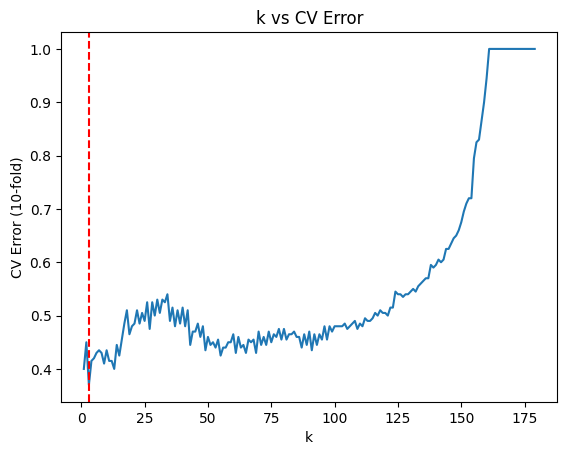

In [ ]:
# Visualize n-fold CV error (average accuracy) for each K
k = range(1, 180)

plt.plot(k, k_cvError)

# Draw a vertical line at the x position where y is maximum
plt.axvline(x=best_k, color='red', linestyle='--', label=f'Max Value: {min_error}')

plt.xlabel('k')
plt.ylabel('CV Error (10-fold)')
plt.title('k vs CV Error')
plt.show()

## Question 3.2:

In [ ]:
# Testing kNN with optimal k on unseen test data

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(f"Test error = {cvError(y_test, y_pred)}")
print("________________________________")
print("TP FP \nFN TN")
print("--------------------------------")
print("kNN from Sklearn")
print(f"\nConfusion matrix (sklearn): k = {best_k}")
print(confusion_matrix(y_test, y_pred))

Test error = 0.3067
________________________________
TP FP 
FN TN
--------------------------------
kNN from Sklearn

Confusion matrix (sklearn): k = 3
[[3565 1632]
 [1435 3368]]


# Part 4: Bayes Rule Classifier


## Part 4.1:

The calculations for Bayes Rule for Binary Classification given in the assignment:

$$\sum_{l = 1}^{10}exp(-||\textbf{x} - \textbf{m}_{l1}||^2/(2s^2) \geq \sum_{l = 1}^{10}exp(-||\textbf{x} - \textbf{m}_{l0}||^2/(2s^2)  $$

This rule is implemented in the ```Bayes_Rule_Classifier``` function and uses reshaping and broadcasting in Numpy to avoid loops. A Citation is Darin Zhen's CampusWire post #35 for the idea and the Numpy docs for how to use it: https://numpy.org/devdocs/user/basics.broadcasting.html


Also instead of dividing the two probabilities & comparing to 1:
$$\dfrac{P(Y = 1 | X = x)}
{P(Y = 0 | X = x)}
≥ 1$$

it is more efficient to compare the 2 proababilites as shown in the calculation part as we avoid the extra division computation.


In [ ]:
# Input: the test matrix x_test, using this function assumes we have m1, m0 and s initalized
# Output: The y vector of predictions, for each element, if it is true it belongs to class 1, otherwise class 0
def Bayes_Rule_Classifier(x_test):
  # Reshape X matrix to work with broadcasting
  x_test = x_test[:, np.newaxis, :] # (N, 1, 2)

  # Calculate m1 & m0 sums
  # Numpy Broadcasting makes x_test & m1/m0 each have shape (N, 10, 2), so subtraction is possible

  sum_m1 = (np.exp(-((x_test - m1)**2).sum(axis=2) / (2 * s**2))).sum(axis=1) # || (N, 10, 2) - (N, 10, 2) ||^2 -> (N, 10)
  sum_m0 = (np.exp(-((x_test - m0)**2).sum(axis=2) / (2 * s**2))).sum(axis=1) # Then summing over the centers after exponentiation gives shape (N,1)

  # Then use the rule for classification
  return (sum_m1 >= sum_m0)


## Part 4.2:

Results after running on test data

In [ ]:
y_pred = Bayes_Rule_Classifier(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
print("TP FP \nFN TN")
print("---------------------------------")
print("Bayes Rule Classifier from scratch")
print(conf_matrix)

TP FP 
FN TN
---------------------------------
Bayes Rule Classifier from scratch
[[3993 1483]
 [1007 3517]]


# Part 5: Simulation Study


In [ ]:
knn_error = []
CVknn_error = []
CVknn_k = []
bayes_error = []

for i in range(50):
  # Generate train data
  csize = 10
  p = 2
  s = 1
  n = 100
  id1 = np.random.randint(csize, size = n)
  id0 = np.random.randint(csize, size = n)
  X_train = np.random.normal(size = (2 * n, p)) * s \
              + np.concatenate([m1[id1,:], m0[id0,:]])
  y_train = np.concatenate(([1]*n, [0]*n))

  # Generate test data
  n = 5000
  id1 = np.random.randint(csize, size = n)
  id0 = np.random.randint(csize, size = n)
  X_test = np.random.normal(size = (2 * n, p)) * s \
              + np.concatenate([m1[id1,:], m0[id0,:]])
  y_test = np.concatenate(([1]*n, [0]*n))

  # 5.1 KNN with k=7
  knn = KNeighborsClassifier(n_neighbors=7)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)

  knn_error.append(cvError(y_test, y_pred))

  # 5.2 KNN with K chosen by 10-fold CV
  n_folds = 10
  all_CV_errors = []

  train_data = np.concatenate((X_train, y_train.reshape(-1,1)), axis=1)
  train_data_shuffled = shuffle(train_data, random_state=12)

  for k in range(1, 180):
    all_CV_errors.append(cv_kNN(train_data_shuffled, k, n_folds))

  min_error = np.min(all_CV_errors)

  # Logging the best k
  best_k_indices = np.where(all_CV_errors == min_error)[0]
  best_k = max(best_k_indices + 1)
  CVknn_k.append(best_k)

  # Logging the test error for best k
  knn = KNeighborsClassifier(n_neighbors=best_k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  CVknn_error.append(cvError(y_test, y_pred))

  # 5.3 Bayes classifier
  y_pred = Bayes_Rule_Classifier(X_test)
  bayes_error.append(cvError(y_test, y_pred))

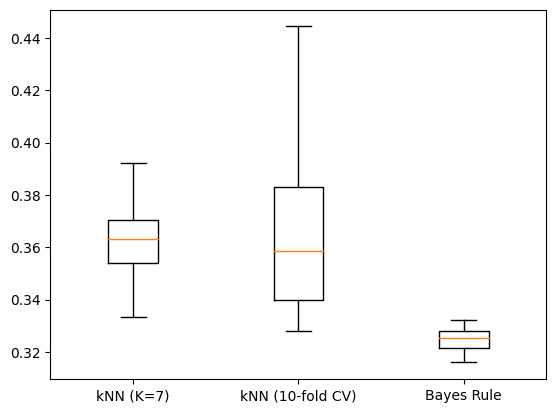

In [ ]:
# Graph
plt.boxplot([knn_error, CVknn_error, bayes_error])
plt.xticks([1, 2, 3], ['kNN (K=7)', 'kNN (10-fold CV)', 'Bayes Rule']);

In [ ]:
# Numerical Report
print(np.min(CVknn_k))
print(np.max(CVknn_k))
print(np.median(CVknn_k))
print(np.percentile(CVknn_k, 25))
print(np.percentile(CVknn_k, 75))

1
68
8.0
3.5
19.75
